# COMP5318 Week 3: Linear and Logistic Regression

## 1. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import signal
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

## 2. Introduction

Linear models for regression and classification are widely used in practice and have been extensively studied in statistics and machine learning. In this tutorial we will show how to implement in Python four algorithms:
- for regression tasks: the strandard linear regression and its two variations ridge and Lasso
- for classification tasks: logistic regression.

We start with regression tasks. We will first generate a simple dataset caled <b>Waves</b> to illustrate how the standard linear regression works.

Text(0, 0.5, 'Target')

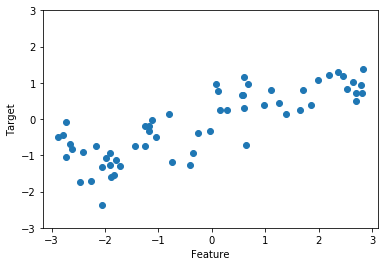

In [2]:
# Create the wave datset - a simple dataset that we will use to illustrate regresion
# It has a single input feature and a numeric target variable
def make_wave(n_samples):
    rnd = np.random.RandomState(42)
    x = rnd.uniform(-3, 3, size=n_samples)
    y_no_noise = (np.sin(4 * x) + x)
    y = (y_no_noise + rnd.normal(size=len(x))) / 2
    return x.reshape(-1, 1), y

X,y = make_wave(60)
plt.plot(X,y,'o')
plt.ylim(-3,3)
plt.xlabel("Feature")
plt.ylabel("Target")

## 3. Linear regression (standard version)

This is the classical linear regression version. It finds the parameters <b>w</b> and <b>b</b> that minimize the mean squared error between the predicted and target values on the training data:

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
lr = LinearRegression().fit(X_train, y_train)
print("lr.coef_:",lr.coef_)
print("lr.intercept_:", lr.intercept_)

lr.coef_: [0.39390555]
lr.intercept_: -0.031804343026759746


The parameters of the linear regression are lr.coef_and lr.intercept_,corresponding to <b>w</b> and <b>b</b> respectively. 

lr.coef_ is a NumPy array with one entry per feature; in our case it is a single number as we have one input feature.

lr.intercept_ is always a single number. 

Let's test the performance of the linear regression model on both the training and test sets. The method <b>score</b> will calculate the coefficient of determination R^2:

In [4]:
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.67
Test set score: 0.66


We can see that the two R^2 values are very similar, so there is no overfitting. On the other hand R^2=0.66-0.67 is not a very good result.

Now let's take a look at how linear regression performs on a more complex real dataset. We will use the <b>Boston Housing dataset</b> which is available from <b>sklearn</b>. The task is to predict the median value of homes in Boston, based of information such as crime rate, highway accessibility, etc. It contains 506 examples, described with 13 numerical features and the target variable is also numeric. 

In [5]:
from sklearn.datasets import load_boston
boston = load_boston()
print("Data shape:", boston.data.shape)

Data shape: (506, 13)


In [6]:
print("Keys of Boston Housing dataset:\n", boston.keys())

Keys of Boston Housing dataset:
 dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


In [7]:
#print("Feature names:", boston['feature_names'])
#print("Data:", boston['data'][:5])

We will use a modified version of this dataset, caled the <b>Extended Boston Housing</b>, which includes the original 13 features and also 91 additional features which are derived from the original features, so 104 features in total. 

In [8]:
#generating the Extended Boston Housing Dataset
def load_extended_boston():
    boston = load_boston()
    X = boston.data
    X = MinMaxScaler().fit_transform(boston.data)
    X = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X)
    return X, boston.target

In [9]:
X,y = load_extended_boston()
print("X.shape:", X.shape)

X.shape: (506, 104)


Let's build a linear regression model as before and test it on the training and test sets:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
lr = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.95
Test set score: 0.61


There is a big difference between the performance on the training and test sets - excellent on the training set and poor on the test set. This indicates overfitting. 

In the standard linear regression we can't control the model complexity to avoid overfitting. But there are other linear regresion versions where we can do this, e.g. ridge regression and Lasso regression. The main idea is to <i>regularize</i> the model by adding restrictions, e.g. to constrain the values of the coefficients <b>w</b>. <i>Regularization</i> means explicitely restricting a model to avoid overfitting. 

## 4. Ridge regression

In ridge regression there are additional restrictions on the coefficients <b>w</b> - their values should be as small as possible (close to 0), in addition to predicting well on the training data. A more restricted model is less likely to overfit. The particular kind of regularization used in ridge regression is called L2 regularization.

Let's run ridge regression on the Extended Boston Housing dataset:

In [11]:
#Building the ridge regression model
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_train, y_train)

#Evaluating it on the training and test set
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

Training set score: 0.89
Test set score: 0.75


Compared to the standard linear regression, the training set score is lower while the test set score is higher. The two scores are now closer, so there is less evidence for overfitting. This is consistent with our expectation that a more constrained model is likely to reduce overfiting. 

We can control the trade-off between model simplicity (near-zero coefficients) and training set performance using the parameter <b>alpha</b>. In the example above, we used the defaul value: <b>alpha</b>=1. 

Increasing <b>alpha</b> makes the coefficients smaller (closer to 0). This typically decreases the performance on the training set but may improve the performance on the test set (i.e. improve generalization, this is what we are interested in):


In [12]:
#alpha=10
ridge10 = Ridge(alpha=10).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge10.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge10.score(X_test, y_test)))

Training set score: 0.79
Test set score: 0.64


On the other hand, decreasing <b>alpha</b> means less restricted coefficients. For very small values of <b>alpha</b>, ridge regression will behave similarly to the standard linear regression:

In [13]:
#alpha=0.01
ridge01 = Ridge(alpha=0.01).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge01.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge01.score(X_test, y_test)))

Training set score: 0.94
Test set score: 0.70


The optimal value of <b>alpha</b> depends on the dataset and is determined by experimenting with different values. We will study methods how to do this later.

## 5. Lasso regression

Lasso is an alternatrive version of linear regression which uses regularization. As in ridge regression, Lasso also restricts the coefficients to be close to 0, but in a different way, by using the so called L1 regularization. The result is that some coefficients will become exactly 0. This means that their corresponding features will be ignored by the regression model and can be seen as a form of feature selection. The advantage of using less features is that the model is simpler, easier to interpret and shows the most important features.

Running Lasso on the Extended Boston Housing dataset:

In [14]:
from sklearn.linear_model import Lasso

lasso = Lasso().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

Training set score: 0.29
Test set score: 0.21
Number of features used: 4


The R^2 scores are very low on both the training and test datasets but Lasso used only 4 features out of the 104. This indicates underfitting, 4 features are not enough to learn the data.

As in ridge regression, Lasso also has a regularization parameter <b>alpha</b> that controls how strongly the coefficients are pushed towards 0. We can experiment with different values, which will also change the number of features:

In [15]:
# alpha=0.01
# we increase the default setting of "max_iter",
# otherwise the model would warn us that we should increase max_iter.
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso001.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso001.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso001.coef_ != 0))

Training set score: 0.90
Test set score: 0.77
Number of features used: 33


The performance on the test set is the same as what we achieved with ridge regression (R^2=0.77) but now we are using only 33 of the 104 features. This is an advantage as the model is easier to interpret and we can also see which are the most important features.

If the value of <b>alpha</b> is too low, the effect of regularization is removed and Lasso performs similarly to the standard linear regression, showing overfitting for our dataset:

In [16]:
# alpha=0.0001
lasso00001 = Lasso(alpha=0.0001, max_iter=100000).fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso00001.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso00001.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso00001.coef_ != 0))

Training set score: 0.95
Test set score: 0.64
Number of features used: 96


Task: Experiment with different values of <b>alpha</b> and observe the performance.

## 6. Logistic regression

Logistic regression is used for classification tasks. Despite its name, logistic regression is a classification algorithm and should not be confused with linear regression.

We will demonstrate how to apply LogisticRegression from sklearn to the <b>Breast Cancer dataset</b>. Let's first look at the data:

In [17]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
print("Keys of breast cancer dataset:\n", cancer.keys())
print("Target names:", cancer['target_names'])
print("Feature names:", cancer['feature_names'])

Keys of breast cancer dataset:
 dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])
Target names: ['malignant' 'benign']
Feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


Now let's apply logistic regression:

In [18]:
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print("Accuracy on trainig set: {:.3f}".format(logreg.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(logreg.score(X_test, y_test)))

Accuracy on trainig set: 0.955
Accuracy on test set: 0.958


C:\Users\irena\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Task: To clear the warning we need to specify the solver, i.e. the algorithm used to find the model parameters <b>w</b> and <b>b</b>. For example, try these:  

In [19]:
logreg = LogisticRegression(solver='liblinear')    
logreg = LogisticRegression(solver='lbfgs', max_iter=5000)  

Similarly to ridge and lasso regression, LogisticRegression has a regularization parameter - it is <b>C</b> not <b>alpha</b> - which controls the trade-off between fitting the training data and finding coefficients <b>w</b> close to 0. High values of <b>C</b> put more emphasis on fitting the training data and low values put more emphasis on finding <b>w</b> close to 0, which typically decreases the performance on the training set but may result in better generalization. 

In the code above we used the default value of <b>C</b>=1 and it worked well. You can experiment with different values of <b>C</b> and observe the result.

## Summary

In [20]:
lr = LinearRegression().fit(X_train, y_train)
ridge = Ridge().fit(X_train, y_train)
lasso = Lasso().fit(X_train, y_train)
logreg = LogisticRegression(solver='liblinear').fit(X_train, y_train)

## Acknowledgements

This tutorial is based on:

Andreas C. Mueller and Sarah Guido (2016). Introduction to Machine Learning with Python: A Guide for Data Scientists, O'Reilly.